## Overview
This part will describe the code implementation for the training model. There are five main steps to training an ML model. 
- The first step is to set the MLFlow experiment for diabetes prediction and load the diabetes dataset. 
- The second step is split into training 80% and test 20% sets. 
- In the third step select an algorithm, set the hyperparameters for it and run it. 
- The fourth step evaluates the result of the model run. 
- The last step deploy it. 

The complete activity diagram for constructing the model is shown in the diagram. 
![Training Activity Diagram](https://static.wixstatic.com/media/e5d689_4c960f43821044daab416cb7db14cb7b~mv2.jpg/v1/fill/w_1082,h_278,al_c,lg_1,q_80,enc_auto/e5d689_4c960f43821044daab416cb7db14cb7b~mv2.jpg)

As we know, there are lots of prediction-related algorithms, such as linear models, logistic regression, SVM, knn, bagging, random forest, etc. Coding the ML models using the four classic algorithms and comparing them to find the most suitable one. We use the open-source algorithm library scikit-learn.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score,precision_recall_curve
import mlflow
#load dataset
df = pd.read_csv("./diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [17]:
#check missed column
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [18]:
# check the recoreds numer and column
df.shape

(100000, 9)

In [19]:
# delete duplicated data
df = df.drop_duplicates()
df.duplicated().sum()
# check the recoreds numer and column
df.shape

(96146, 9)

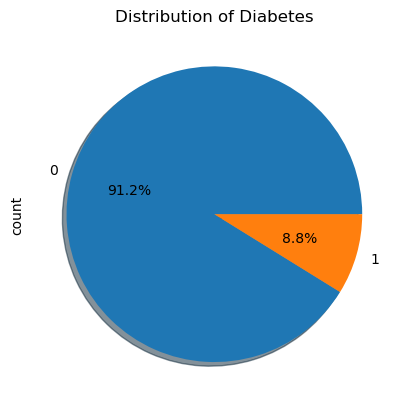

In [20]:
df.diabetes.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', shadow = True)
plt.title('Distribution of Diabetes')
plt.show()

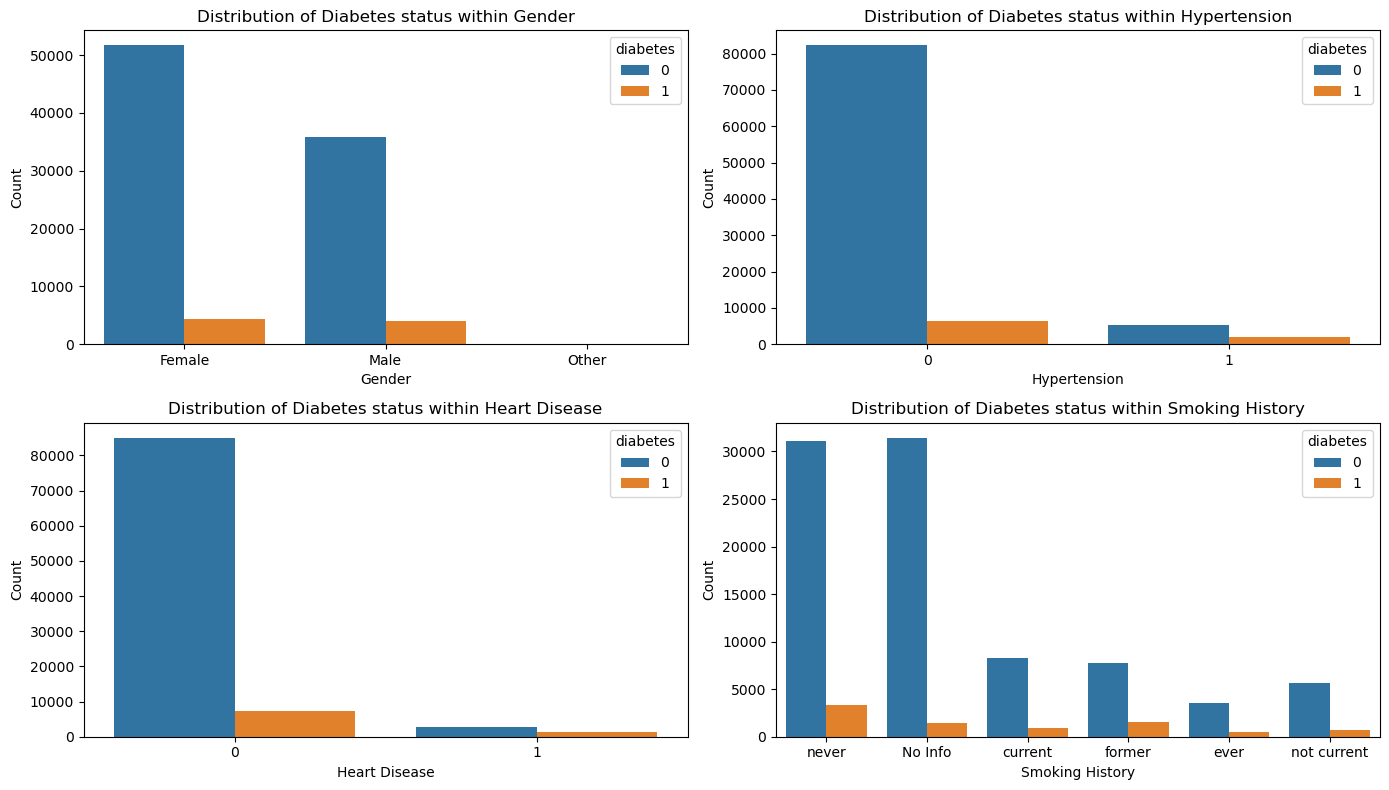

In [21]:
# feature analysing
# ploting categorical features alongiside target feature
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

# Distribution of gender
sns.countplot(x="gender", data=df,hue = 'diabetes',ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Diabetes status within Gender")
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("Count")

# Distribution of Hypertension
sns.countplot(x="hypertension", data=df, hue = 'diabetes', ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Diabetes status within Hypertension")
axes[0, 1].set_xlabel("Hypertension")
axes[0, 1].set_ylabel("Count")

# Chart 3: Distribution of heart disease
sns.countplot(x="heart_disease", hue = 'diabetes',data=df, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Diabetes status within Heart Disease")
axes[1, 0].set_xlabel("Heart Disease")
axes[1, 0].set_ylabel("Count")

# Chart 4: Distribution of smoking history
sns.countplot(x="smoking_history", data=df, hue = 'diabetes', ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Diabetes status within Smoking History")
axes[1, 1].set_xlabel("Smoking History")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

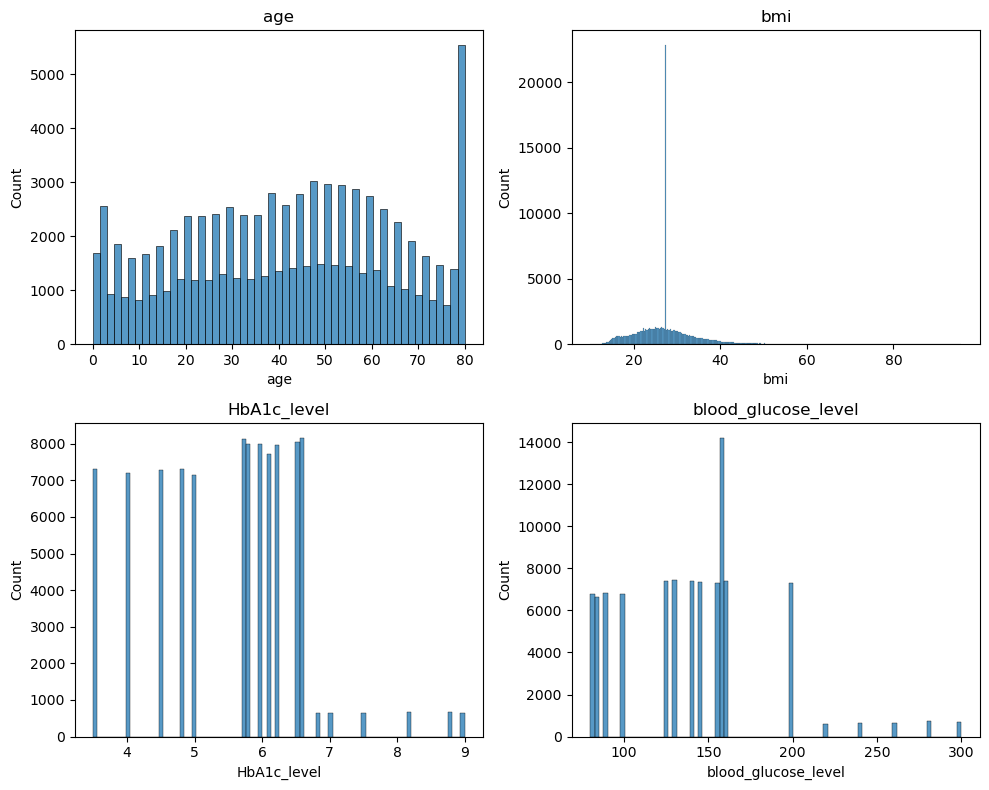

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [22]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# List of numeric feature columns
numeric_features = ['age', 'bmi','HbA1c_level', 'blood_glucose_level']

# Loop through numeric features and plot them
for i, feature in enumerate(numeric_features):
    row = i // 2
    col = i % 2
    sns.histplot(df[feature], ax=axes[row, col])
    axes[row, col].set_title(f'{feature}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
df.describe()

In [23]:
# enumerate type is encoded from string to 0,1
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'])
df_encoded.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Female', 'gender_Male',
       'gender_Other', 'smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')

In [24]:
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,True,False,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,True,False,False,True,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,False,True,False,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,True,False,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,False,True,False,False,True,False,False,False,False


In [25]:
columns = ['gender_Female', 'gender_Male',
       'gender_Other', 'smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current']
# cast type to int  
df_encoded[columns] = df_encoded[columns].astype(int)
df_encoded_metamorphic_test = df_encoded.copy() # for metamorphic test
# ensure that all features have the same scale or unit variance for algorithm. 
# in order to use metamorphic test, we remove the scaler
# for numeric features
# scaler = StandardScaler()
# df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])
# df_encoded.head(20)

In [26]:
X = df_encoded.drop('diabetes', axis = 1)
y = df_encoded.diabetes
# split the source(X) and target(y) into train and test  20% for test, 80% for training
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((76916, 15), (76916,), (19230, 15), (19230,))

In [27]:
y_train.value_counts()

diabetes
0    70155
1     6761
Name: count, dtype: int64

In [28]:
# keep the training data balance to reduce bias and overfitting
smote = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train_resampled, y_train_resampled =smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

diabetes
0    70155
1    70155
Name: count, dtype: int64

2023/09/27 23:25:42 INFO mlflow.tracking.fluent: Experiment with name 'diabetes_prediction' does not exist. Creating a new experiment.


Model: Logistic_Regression
Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     17509
           1       0.62      0.74      0.67      1721

    accuracy                           0.94     19230
   macro avg       0.80      0.85      0.82     19230
weighted avg       0.94      0.94      0.94     19230

roc_auc:
0.8466923078888723


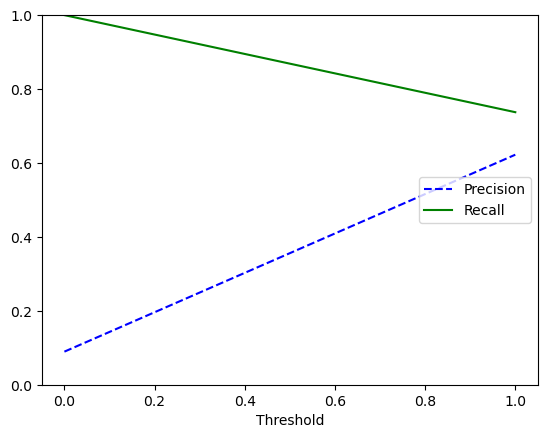

Confusion Matrix:
[[16739   770]
 [  452  1269]]


/Users/jamesoujamesou/opt/anaconda3/envs/machine_learning/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Details logged at: http://localhost:5000/
Run ID: 2946fc76ebb6497db0557afacfb1b25f
Model: Random_Forest
Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17509
           1       0.88      0.71      0.79      1721

    accuracy                           0.97     19230
   macro avg       0.93      0.85      0.89     19230
weighted avg       0.96      0.97      0.96     19230

roc_auc:
0.8525814017321679


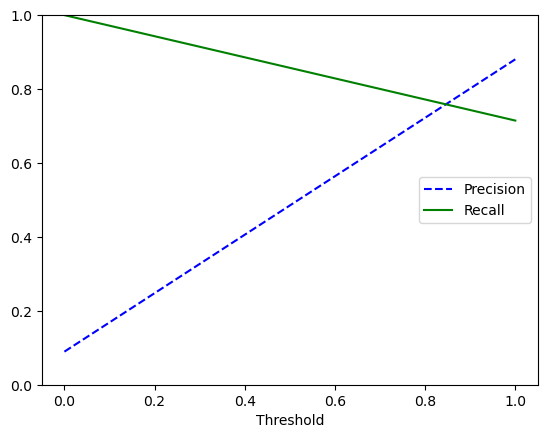

Confusion Matrix:
[[17342   167]
 [  491  1230]]
Details logged at: http://localhost:5000/
Run ID: bd068fb48b2347f9b3d9ba958103b851
Model: SVM
Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     17509
           1       0.43      0.90      0.58      1721

    accuracy                           0.88     19230
   macro avg       0.71      0.89      0.76     19230
weighted avg       0.94      0.88      0.90     19230

roc_auc:
0.8925169852881173


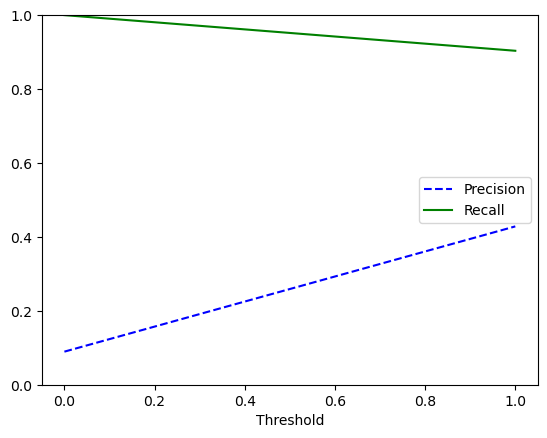

Confusion Matrix:
[[15434  2075]
 [  166  1555]]
Details logged at: http://localhost:5000/
Run ID: 8d54aa04abc44b6998c8961df40daf29
Model: K_Nearest_Neighbors
Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     17509
           1       0.44      0.79      0.56      1721

    accuracy                           0.89     19230
   macro avg       0.71      0.84      0.75     19230
weighted avg       0.93      0.89      0.90     19230

roc_auc:
0.8443204223782778


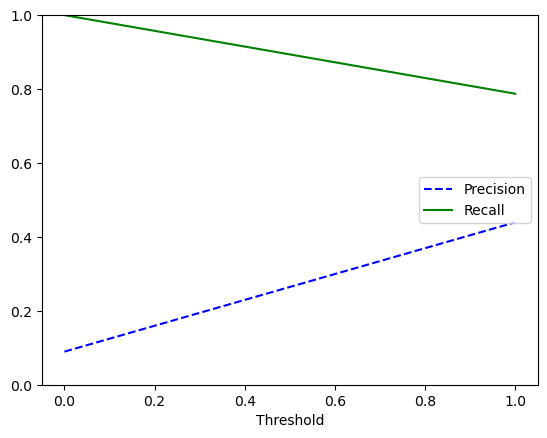

Confusion Matrix:
[[15781  1728]
 [  366  1355]]
Details logged at: http://localhost:5000/
Run ID: dd86ad2214064d8c8566c85df8a438d8


In [29]:
run = mlflow.active_run()
if run:
    print("Active run_id: {}".format(run.info.run_id))
    mlflow.end_run()

mlflow.set_experiment('diabetes_prediction') 
mlflow.set_tracking_uri("http://localhost:5000/") # Actual Server URI instead of localhost
experiment = mlflow.get_experiment_by_name("diabetes_prediction")
# set classfiers and select the best performance one from them
params = {
    'criterion': 'entropy',
    'max_depth': 1000,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'n_estimators': 600,
    ###
    'n_jobs': -1,
    'random_state': 42
}
classifiers = [
        ("Logistic_Regression", LogisticRegression(max_iter=10000)),
        # Log parameters, different model have different parameters
        ("Random_Forest", RandomForestClassifier(**params)),
        #("Random_Forest", RandomForestClassifier()),
        ("SVM", SVC()), #spend on a lot of time
        ("K_Nearest_Neighbors", KNeighborsClassifier())
        ]
# Iterate through classifiers, fit, and evaluate them
for name, classifier in classifiers:
    # if "Random_Forest" == name:
    #     mlflow.log_param("n_estimators", 100)
    #     mlflow.log_param("max_depth", 10)
    # Start MLflow run
    with mlflow.start_run(nested=True,run_name=name) as run:
        classifier.fit(X_train_resampled, y_train_resampled)
        y_pred = classifier.predict(X_test)
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.2f}")
        # Display classification report
        report = classification_report(y_test, y_pred)
        print(f"Classification Report:\n{report}")
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
        # Log metrics 
        # print(f"precision:\n{precision}")
        # print(f"recall:\n{recall}")
        # print(f"fscore:\n{fscore}")
        # print(f"support:\n{support}")
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"roc_auc:\n{roc_auc}")
        metrics = {"accuracy":accuracy, 
                   "precision":float(precision[0]), 
                   "recall":float(recall[0]), 
                   "fscore":float(fscore[0]), 
                   "support":float(support[0]), 
                   "roc_auc":float(roc_auc)
        }
        mlflow.log_metrics(metrics)
        mlflow.log_param("model", name)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
        # print(f"precisions:\n{precisions}")
        # print(f"recalls:\n{recalls}")
        # print(f"thresholds:\n{thresholds}")
        #PR diagram
        plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
        plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
        plt.xlabel('Threshold')
        plt.legend(loc='center right')
        plt.ylim([0, 1])
        plt.show()
        # Display confusion matrix
        confusion = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{confusion}")
        mlflow.sklearn.log_model(classifier, name)
        print("Details logged at: %s" % mlflow.get_tracking_uri())
        print("Run ID: %s" % run.info.run_uuid)
        print("=" * 50)
    mlflow.end_run()

In [30]:
# By test the algorithm, we get the best one is Random forest
# the next step we should test the modelling with metamorphic test
model_name = 'Random_Forest'
randomForest = RandomForestClassifier()
# re-training
randomForest.fit(X_train_resampled, y_train_resampled)
y_pred = randomForest.predict(X_test)
# Calculate accuracy
accuracy_radmon_forest = accuracy_score(y_test, y_pred)
print(f"Model: {model_name}")
print(f"Accuracy: {accuracy_radmon_forest}")

Model: Random_Forest
Accuracy: 0.9645345813832553


In [31]:
# increasing the patient's age by 10 years, or by decreasing the patient's bmi by 5%. 
# we choose increasing age by 10 years as an example
# if we get similar accruracy rate with incresing before, which means pass the metamorphic test
# numer features 'age', 'bmi','HbA1c_level', 'blood_glucose_level'
increased_age = 10
df_encoded_metamorphic_test['age'] = df_encoded_metamorphic_test['age'] + increased_age
df_encoded_metamorphic_test.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,90.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,64.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,38.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,46.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,86.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0


In [32]:
# prepare the test data
X = df_encoded_metamorphic_test.drop('diabetes', axis = 1)
y = df_encoded_metamorphic_test.diabetes
# split the source(X) and target(y) into train and test  20% for test, 80% for training
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
# keep the training data balance to reduce bias and overfitting
smote = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train_resampled, y_train_resampled =smote.fit_resample(X_train, y_train)
randomForest = RandomForestClassifier(**params)
# re-training
randomForest.fit(X_train_resampled, y_train_resampled)
# joblib.dump(model, "rf.pkl") #no need, use MFflow online model
y_pred = randomForest.predict(X_test)
# Calculate accuracy
accuracy_metamorphic_test = accuracy_score(y_test, y_pred)
# metamorphic_relation
print(f"Model: {model_name}")
print(f"Accuracy: {accuracy_metamorphic_test}")
if str(accuracy_metamorphic_test)[0:4] == str(accuracy_radmon_forest)[0:4]:
    print(f"Metamorphic relation holds: Prediction for accuracy ({accuracy_radmon_forest}). "
          f"After increased age by ({increased_age} years), the accuracy ({accuracy_metamorphic_test}) is similar.")
else:
    print(f"Metamorphic relation does not hold.")

Model: Random_Forest
Accuracy: 0.9657826313052522
Metamorphic relation holds: Prediction for accuracy (0.9645345813832553). After increased age by (10 years), the accuracy (0.9657826313052522) is similar.


In [33]:
dict_data = {"age": 39, "hypertension": 1, "heart_disease": 0, "bmi": 79, "HbA1c_level": 8.8, "blood_glucose_level": 145, "gender_Female": 1, "gender_Male": 0, "gender_Other": 0, "smoking_history_No Info": 1, "smoking_history_current": 0, "smoking_history_ever": 0, "smoking_history_former": 0, "smoking_history_never": 0, "smoking_history_not current": 0},
print(type(dict_data))
df = pd.DataFrame.from_dict(dict_data)
print(df)
y_pred = randomForest.predict(df)
print(y_pred)
# Add MLFlow api for collecting the model metric data --Done
# MLFlow tables structure and business structure
# deploy a model file and implement a RestAPI inferface for application --Done
# design a webpage and request the RestAPI after submitting the 'prediction' button to get the prediction result

<class 'tuple'>
   age  hypertension  heart_disease  bmi  HbA1c_level  blood_glucose_level  \
0   39             1              0   79          8.8                  145   

   gender_Female  gender_Male  gender_Other  smoking_history_No Info  \
0              1            0             0                        1   

   smoking_history_current  smoking_history_ever  smoking_history_former  \
0                        0                     0                       0   

   smoking_history_never  smoking_history_not current  
0                      0                            0  
[1]
